<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/007_TensorFlow_Proj_Seven_CNN_MNIST_FashionMNIST_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocess

### Libs

In [1]:
import sys, os, warnings, itertools
import platform
import numpy as np
import pandas as pd
from collections import Counter
# google
from google.colab import drive
# sklearn
import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import one_hot
from tensorflow.config import list_physical_devices, experimental
from tensorflow.keras import Model, Sequential, layers, callbacks, applications, optimizers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.utils import plot_model, to_categorical, image_dataset_from_directory
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, AUC
# vis
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
print("Python platform: {}".format(platform.platform()))
print("Python: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Scikit-learn version: {}".format(sk.__version__))

Python platform: Linux-6.1.85+-x86_64-with-glibc2.35
Python: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Tensorflow version: 2.17.0
Pandas version: 2.2.2
Scikit-learn version: 1.5.2


### Settings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# setup gpu
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices("GPU")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set for device:", physical_devices[0])
    except Exception as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

GPU memory growth set for device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
# mount google drive
drive.mount("/content/drive")

Mounted at /content/drive


## MNIST Date Base

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
print("x_train:", x_train.shape, type(x_train))
print("y_train:", y_train.shape, type(y_train))
print("x_test:", x_test.shape, type(x_test))
print("y_test:", y_test.shape, type(y_test))

x_train: (60000, 28, 28) <class 'numpy.ndarray'>
y_train: (60000,) <class 'numpy.ndarray'>
x_test: (10000, 28, 28) <class 'numpy.ndarray'>
y_test: (10000,) <class 'numpy.ndarray'>


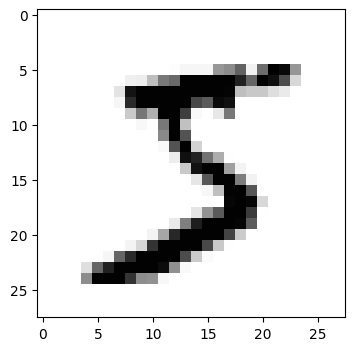

In [8]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[0], cmap="Greys")
plt.show()

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

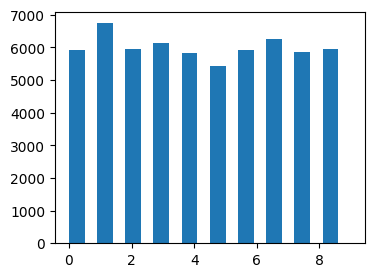

In [9]:
plt.figure(figsize=(4,3))
plt.hist(y_train, bins=10, width=0.5)

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

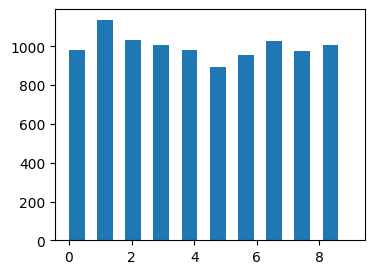

In [10]:
plt.figure(figsize=(4,3))
plt.hist(y_test, bins=10, width=0.5)

In [11]:
def ConvNet_builder():
  inputs = layers.Input(shape=(x_train.shape[1],x_train.shape[2],1), name="input_layer")
  feature = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="first_conv_layer")(inputs)
  feature = layers.MaxPool2D(pool_size=(2,2), name="first_pool_layer")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="second_conv_layer")(feature)
  feature = layers.MaxPool2D(pool_size=(2,2), name="second_pool_layer")(feature)
  feature = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding="valid",
                          activation="relu", name="third_conv_layer")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=64, activation="relu", name="first_dense_layer")(feature)
  outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="cnn_arc")
  model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [12]:
model = ConvNet_builder()
model.summary()

Model: "cnn_arc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_conv_layer (Conv2D)            │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_pool_layer (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_conv_layer (Conv2D)           │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_pool_layer (MaxPooling2D)     │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_conv_layer (Conv2D)            │ (None, 3, 3, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dense_layer (Dense)            │ (None, 64)                  │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,426 (220.41 KB)

 Trainable params: 56,426 (220.41 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model_callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto'),
                   callbacks.ModelCheckpoint(filepath="mnist_cnn.keras",save_best_only=True, monitor="val_loss")]
history = model.fit(x=x_train, y=y_train, validation_split=0.2, epochs=10,
                    batch_size=64, callbacks=[model_callbacks])

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7929 - loss: 2.0680 - val_accuracy: 0.9762 - val_loss: 0.0823
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9751 - loss: 0.0845 - val_accuracy: 0.9765 - val_loss: 0.0834
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9833 - loss: 0.0586 - val_accuracy: 0.9845 - val_loss: 0.0616
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9878 - loss: 0.0428 - val_accuracy: 0.9849 - val_loss: 0.0679
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9902 - loss: 0.0365 - val_accuracy: 0.9863 - val_loss: 0.0666
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9910 - loss: 0.0310 - val_accuracy: 0.9763 - val_loss: 0.1112
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9916 - loss: 0.0291 - val_accuracy: 0.9828 - val_loss: 0.0855
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9924 - loss: 0.0287 - val_accuracy: 0

In [14]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9825 - loss: 0.0962


[0.08213289827108383, 0.9836999773979187]

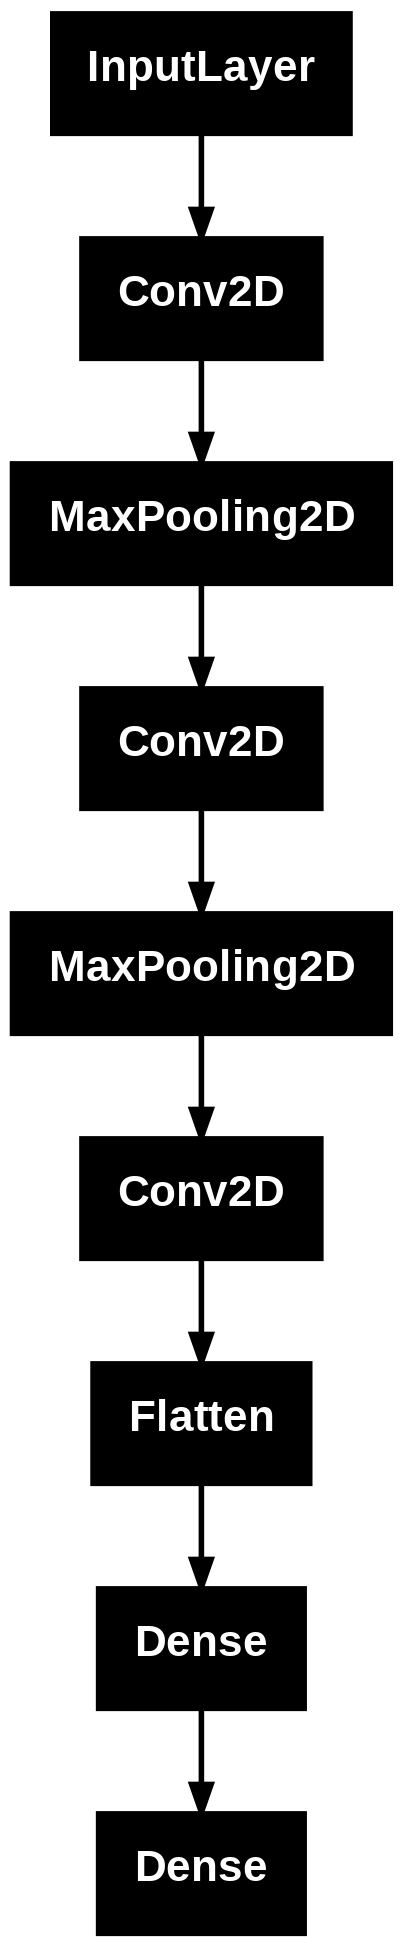

In [15]:
plot_model(model)

In [16]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [17]:
metrics = pd.DataFrame(history.history)
metrics

,accuracy,loss,val_accuracy,val_loss
0,0.907208,0.533777,0.976167,0.082349
1,0.976562,0.079900,0.976500,0.083417
2,0.983354,0.058768,0.984500,0.061607
3,0.987229,0.044547,0.984917,0.067859
4,0.989646,0.038303,0.986333,0.066571
5,0.990375,0.033571,0.976333,0.111207
6,0.991417,0.030572,0.982833,0.085468
7,0.992229,0.027695,0.984917,0.076456
8,0.993813,0.023047,0.986667,0.075091
9,0.993792,0.024307,0.983333,0.096039


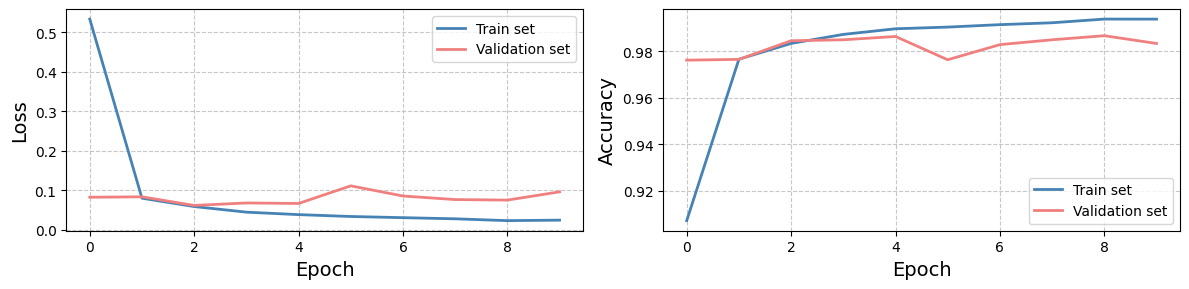

In [18]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='lightcoral', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='lightcoral', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [19]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [20]:
classification_report(y_test,pred)

'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99       980\n           1       1.00      0.98      0.99      1135\n           2       1.00      0.96      0.98      1032\n           3       0.97      1.00      0.98      1010\n           4       0.98      0.99      0.99       982\n           5       0.99      0.98      0.98       892\n           6       0.98      0.99      0.99       958\n           7       0.96      0.99      0.98      1028\n           8       0.98      0.98      0.98       974\n           9       0.98      0.98      0.98      1009\n\n    accuracy                           0.98     10000\n   macro avg       0.98      0.98      0.98     10000\nweighted avg       0.98      0.98      0.98     10000\n'

In [21]:
conf_mat = confusion_matrix(y_test,pred)

<Axes: >

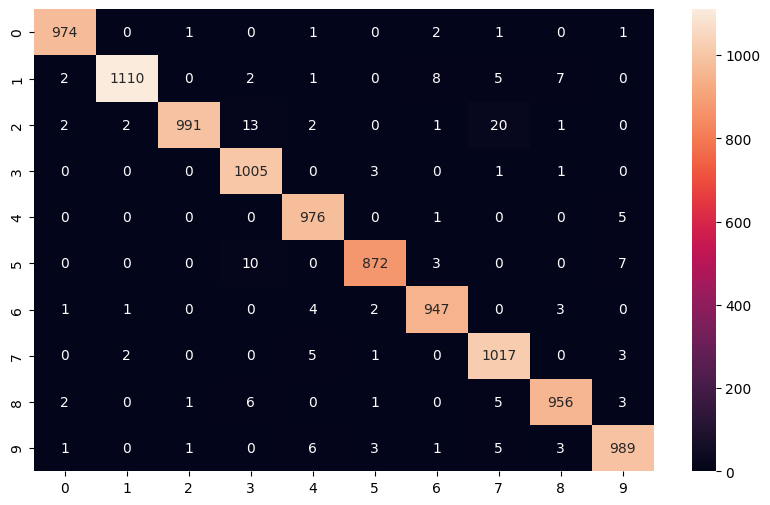

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat,annot=True, fmt='g')

In [23]:
misclf_img = [i for i, img in enumerate(y_test!=pred) if img==True]
len(misclf_img)

163

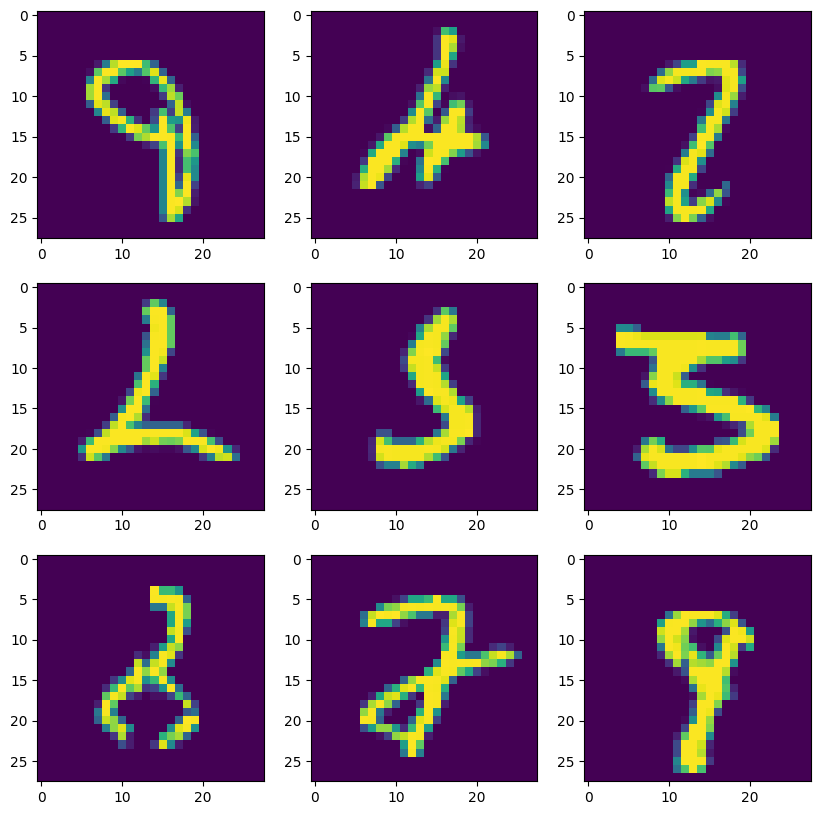


true_label [9, 4, 2, 2, 5, 3, 8, 2, 9]
wrong_pred [7, 6, 7, 1, 3, 5, 3, 7, 8]


In [24]:
plt.figure(figsize=(10,10))
true_label = []
wrong_pred = []
for idx , num in enumerate(misclf_img[:9]):
  ax = plt.subplot(3,3,idx+1)
  plt.imshow(x_test[num])
  true_label.append(y_test[num])
  wrong_pred.append(pred[num])
plt.show()
print("\ntrue_label", true_label)
print("wrong_pred", wrong_pred)

## Fashion MNIST Date Base

In [25]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
print("x_train:", x_train.shape, type(x_train))
print("y_train:", y_train.shape, type(y_train))
print("x_test:", x_test.shape, type(x_test))
print("y_test:", y_test.shape, type(y_test))

x_train: (60000, 28, 28) <class 'numpy.ndarray'>
y_train: (60000,) <class 'numpy.ndarray'>
x_test: (10000, 28, 28) <class 'numpy.ndarray'>
y_test: (10000,) <class 'numpy.ndarray'>


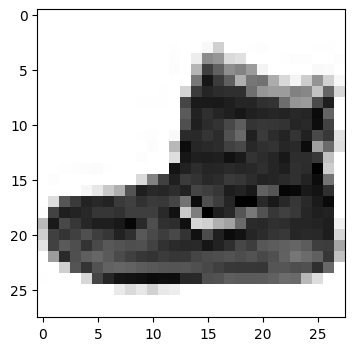

In [27]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[0], cmap="Greys")
plt.show()

In [28]:
Counter(y_train)

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

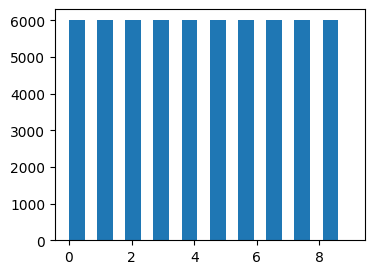

In [29]:
plt.figure(figsize=(4,3))
plt.hist(y_train, bins=10, width=0.5)

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

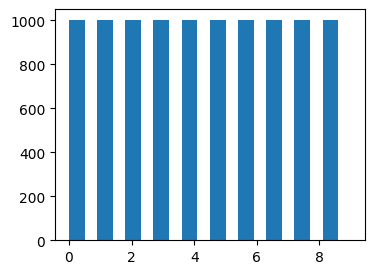

In [30]:
plt.figure(figsize=(4,3))
plt.hist(y_test, bins=10, width=0.5)

In [31]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_train = x_train / 255.0
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_test = x_test / 255.0

In [32]:
y_train_enc = to_categorical(y_train, num_classes=10)
y_test_enc = to_categorical(y_test, num_classes=10)

In [33]:
def ConvNetBuilder():

  augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ], name="augmentation")

  inputs = layers.Input(shape=x_train.shape[1:], name="input_layer")
  feature = augmentation(inputs)
  feature = layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="first_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="first_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="second_convnet")(feature)
  feature = layers.AvgPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="second_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="third_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="third_pool")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=32, activation="relu", name="first_dense_layer")(feature)
  feature = layers.Dropout(rate=0.2, name="first_dropout_layer")(feature)
  outputs = layers.Dense(units=10, activation="softmax", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="ConvNet")
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                metrics=[Precision(), AUC(), "accuracy"])
  return model


In [34]:
model = ConvNetBuilder()
model.summary()

Model: "ConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_convnet (Conv2D)               │ (None, 27, 27, 32)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_pool (MaxPooling2D)            │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_convnet (Conv2D)              │ (None, 12, 12, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_pool (AveragePooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_convnet (Conv2D)               │ (None, 5, 5, 64)            │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_pool (MaxPooling2D)            │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dense_layer (Dense)            │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dropout_layer (Dropout)        │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,418 (130.54 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
callbacks_list = [EarlyStopping(monitor='loss', patience=3)]
monitor = model.fit(x=x_train, y=y_train_enc, validation_split=0.2,
          epochs=10, batch_size=128, callbacks=callbacks_list)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3861 - auc: 0.8297 - loss: 1.6395 - precision: 0.6699 - val_accuracy: 0.6771 - val_auc: 0.9587 - val_loss: 0.8544 - val_precision: 0.8269
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6329 - auc: 0.9458 - loss: 0.9759 - precision: 0.8139 - val_accuracy: 0.7091 - val_auc: 0.9670 - val_loss: 0.7467 - val_precision: 0.8280
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6688 - auc: 0.9563 - loss: 0.8756 - precision: 0.8251 - val_accuracy: 0.6833 - val_auc: 0.9603 - val_loss: 0.8287 - val_precision: 0.7939
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6877 - auc: 0.9610 - loss: 0.8231 - precision: 0.8311 - val_accuracy: 0.7388 - val_auc: 0.9705 - val_loss: 0.7049 - val_precision: 0.8307
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6974 - auc: 0.9633 - loss: 0.7985 - precision: 0.8268 - val_accuracy: 0.6657 - val_auc: 0.9546 - val_loss: 0.8947 - v

In [36]:
metrics = pd.DataFrame(monitor.history)
metrics

,accuracy,auc,loss,precision,val_accuracy,val_auc,val_loss,val_precision
0,0.501667,0.899187,1.332777,0.756417,0.677083,0.958716,0.854421,0.826887
1,0.643458,0.949430,0.943183,0.816757,0.709083,0.967032,0.746715,0.827963
2,0.676250,0.958012,0.858597,0.827573,0.683333,0.960309,0.828736,0.793890
3,0.690292,0.961846,0.814299,0.828007,0.738833,0.970451,0.704917,0.830688
4,0.703792,0.964855,0.781080,0.828032,0.665667,0.954560,0.894674,0.746289
5,0.716750,0.967479,0.751714,0.831497,0.702833,0.963557,0.791505,0.776482
6,0.729125,0.969541,0.725419,0.834630,0.659667,0.947622,0.987187,0.713474
7,0.735313,0.970974,0.706935,0.834754,0.676083,0.958085,0.865643,0.732418
8,0.743500,0.972793,0.685489,0.837471,0.667000,0.954638,0.899427,0.724276
9,0.751229,0.974021,0.667553,0.843501,0.707083,0.957787,0.859169,0.759380


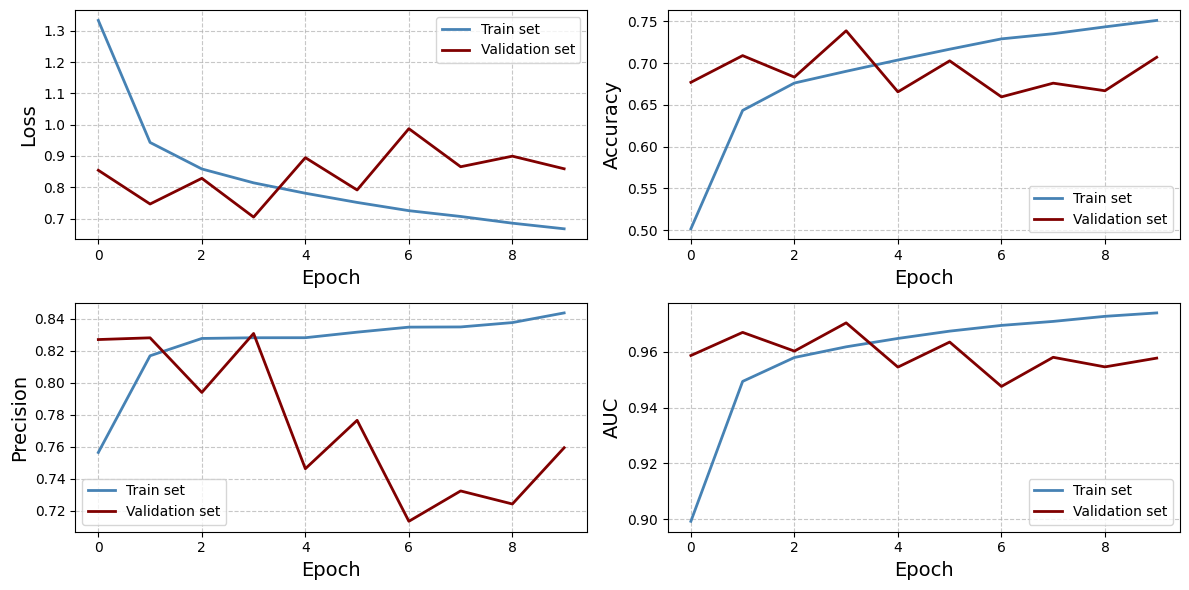

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.plot(metrics["precision"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(metrics["val_precision"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Precision", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.plot(metrics["auc"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(metrics["val_auc"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("AUC", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [38]:
pred = np.argmax(model.predict(x_test), axis=1)
confusion_matrix(y_test, pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[709,   0,  36,  49,   4,  10, 157,   0,  35,   0],
       [  0, 943,   0,  22,   2,   9,  17,   0,   7,   0],
       [  8,   1, 684,   8, 114,   1, 157,   0,  27,   0],
       [ 33,  19,  34, 751,  24,  24,  89,   0,  26,   0],
       [  0,   0, 190,  33, 497,   0, 262,   0,  18,   0],
       [  0,   0,   0,   6,   0, 988,   0,   1,   3,   2],
       [148,   1, 215,  33,  92,   1, 463,   0,  47,   0],
       [  0,   0,   0,   0,   0, 627,   0, 311,   0,  62],
       [  0,   0,  17,   1,  11,  28,  29,   1, 913,   0],
       [  0,   0,   0,   3,   1, 157,   0,  21,   1, 817]])

In [39]:
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.79      0.71      0.75      1000\n           1       0.98      0.94      0.96      1000\n           2       0.58      0.68      0.63      1000\n           3       0.83      0.75      0.79      1000\n           4       0.67      0.50      0.57      1000\n           5       0.54      0.99      0.69      1000\n           6       0.39      0.46      0.43      1000\n           7       0.93      0.31      0.47      1000\n           8       0.85      0.91      0.88      1000\n           9       0.93      0.82      0.87      1000\n\n    accuracy                           0.71     10000\n   macro avg       0.75      0.71      0.70     10000\nweighted avg       0.75      0.71      0.70     10000\n'

## MNIST-Y-CNN

In [40]:
(x_train, _y_train), (x_test, _y_test) = mnist.load_data()

In [41]:
y_train = tf.keras.utils.to_categorical(_y_train)
y_test = tf.keras.utils.to_categorical(_y_test)

In [42]:
num_labels = len(np.unique(_y_train))
input_shape = x_train[0].shape

In [43]:
def get_left_cnn_model(input_shape, input_name="input_layer_on_left", batch_size=512,
                       dropout=0.25, hidden_units=256, pool_size=2):

    inputs = tf.keras.layers.Input(shape=input_shape, name=input_name)
    x = tf.keras.layers.Reshape((input_shape + (1,)), input_shape=input_shape)(inputs)
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="valid", activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.AvgPool2D(2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.AvgPool2D(2)(x)
    outputs = tf.keras.layers.Flatten()(x)
    return inputs, outputs

def get_right_cnn_model(input_shape, input_name="input_layer_on_right", batch_size=512,
                       dropout=0.25, hidden_units=256, pool_size=2):

    inputs = tf.keras.layers.Input(shape=input_shape, name=input_name)
    x = tf.keras.layers.Reshape((input_shape + (1,)), input_shape=input_shape)(inputs)
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="valid", activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.AvgPool2D(2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.AvgPool2D(2)(x)
    outputs = tf.keras.layers.Flatten()(x)
    return inputs, outputs

In [44]:
inputs_left, outputs_left = get_left_cnn_model(input_shape)
inputs_right, outputs_right = get_right_cnn_model(input_shape)

In [45]:
merge = tf.keras.layers.concatenate([outputs_left, outputs_right])

In [46]:
interim = tf.keras.layers.Dense(units=256, activation="relu")(merge)
interim = tf.keras.layers.Dropout(0.2)(interim)
interim = tf.keras.layers.Dense(units=256, activation="relu")(interim)
interim = tf.keras.layers.Dropout(0.2)(interim)
output_layer = tf.keras.layers.Dense(units=num_labels, activation="softmax")(interim)

In [47]:
model = tf.keras.models.Model(inputs=[inputs_left, inputs_right], outputs=output_layer, name="final_model")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "final_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_on_left       │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_on_right      │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 28, 28, 1)      │              0 │ input_layer_on_left[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 28, 28, 1)      │              0 │ input_layer_on_right[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 28, 28, 1)      │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 28, 28, 1)      │              0 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 32)     │            320 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 14, 14, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 14, 14, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 12, 12, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 12, 12, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 6, 6, 64)       │              0 │ conv2d_1[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 6, 6, 64)       │              0 │ conv2d_4[0][0]         │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 6, 6, 64)       │         36,928 │ average_pooling2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 6, 6, 64)       │         36,928 │ average_pooling2d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1  

 Total params: 475,018 (1.81 MB)

 Trainable params: 475,018 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
monitor = model.fit([x_train, x_train], y_train, epochs=2, validation_split=0.2)

Epoch 1/2
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8137 - loss: 0.7004 - val_accuracy: 0.9712 - val_loss: 0.1361
Epoch 2/2
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9678 - loss: 0.1414 - val_accuracy: 0.9797 - val_loss: 0.0959


In [49]:
loss, acc = model.evaluate([x_test, x_test], y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9795 - loss: 0.0907


In [51]:
print("accuracy:", acc)

accuracy: 0.983299970626831


## Transfer Learning

#### Base Model

In [52]:
os.getcwd()

'/content'

In [53]:
working_dir = "/content/drive/MyDrive/DataSets/dogs-vs-cats"

In [54]:
os.listdir(working_dir)

['train', 'valid', 'test']

In [55]:
os.chdir(working_dir)

In [56]:
assert os.getcwd() == working_dir

In [57]:
train_dataset = image_dataset_from_directory(directory="train", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)
validation_dataset = image_dataset_from_directory(directory="valid", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)
test_dataset = image_dataset_from_directory(directory="test", labels='inferred', label_mode='int',
                                             color_mode='rgb', batch_size=32, image_size=(180, 180), shuffle=True)

Found 996 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [58]:
for data_batch, labels_batch in train_dataset:
  print("data batch:", data_batch.shape, type(data_batch))
  print("labels batch:", labels_batch.shape, type(labels_batch))
  break

data batch: (32, 180, 180, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
labels batch: (32,) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [59]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int32)>

In [60]:
def CNN_Builder():
  augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ], name="augmentation")
  inputs = layers.Input(shape=(180, 180, 3), name="input_layer")
  feature = augmentation(inputs)
  feature = layers.Rescaling(1./255, name="rescale")(feature)
  feature = layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="first_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="first_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="second_convnet")(feature)
  feature = layers.AvgPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="second_pool")(feature)
  feature = layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1),
                          padding='valid', activation="relu", use_bias=True,
                          name="third_convnet")(feature)
  feature = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid',
                             name="third_pool")(feature)
  feature = layers.Flatten(name="flatten_layer")(feature)
  feature = layers.Dense(units=32, activation="relu", name="first_dense_layer")(feature)
  feature = layers.Dropout(rate=0.2, name="first_dropout_layer")(feature)
  outputs = layers.Dense(units=1, activation="sigmoid", name="output_layer")(feature)
  model = Model(inputs=inputs, outputs=outputs, name="ConvNet")
  model.compile(optimizer='rmsprop', loss='binary_crossentropy',
                metrics=["accuracy"])
  return model

In [61]:
model = CNN_Builder()
model.summary()

Model: "ConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescale (Rescaling)                  │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_convnet (Conv2D)               │ (None, 179, 179, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_pool (MaxPooling2D)            │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_convnet (Conv2D)              │ (None, 88, 88, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_pool (AveragePooling2D)       │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_convnet (Conv2D)               │ (None, 43, 43, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_pool (MaxPooling2D)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dense_layer (Dense)            │ (None, 32)                  │         903,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_dropout_layer (Dropout)        │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 928,353 (3.54 MB)

 Trainable params: 928,353 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
callbacks_list = [EarlyStopping(monitor='loss', patience=3)]
monitor = model.fit(train_dataset, validation_data=validation_dataset,
                    epochs=10, callbacks=callbacks_list)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.4751 - loss: 0.9539 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - accuracy: 0.4803 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.4898 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.4865 - loss: 0.6986 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5057 - loss: 0.6968 - val_accuracy: 0.5000 - val_loss: 0.6931


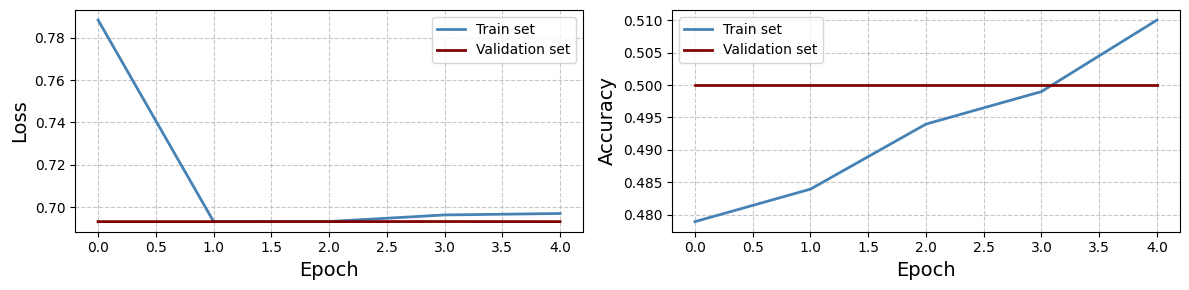

In [63]:
performance = pd.DataFrame(monitor.history)
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(performance["loss"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(performance["val_loss"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(performance["accuracy"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(performance["val_accuracy"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [64]:
model.evaluate(test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.4892 - loss: 0.6932


[0.6931388974189758, 0.5]

#### Feature Extraction Method

In [65]:
conv_base = applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
def get_features_and_labels(dataset):
    features_list = []
    labels_list = []
    for images, labels in dataset:
        preprocessed_images = applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        features_list.append(features)
        labels_list.append(labels)
    return np.concatenate(features_list), np.concatenate(labels_list)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [67]:
inputs = layers.Input(shape=train_features.shape[1:])
features = layers.Flatten()(inputs)
features = layers.Dense(128)(features)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(1, activation="sigmoid")(features)
model = Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,638,657 (6.25 MB)

 Trainable params: 1,638,657 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
monitor = model.fit(x=train_features, y=train_labels, epochs=10,
                    validation_data=(val_features, val_labels))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8060 - loss: 24.6926 - val_accuracy: 0.9800 - val_loss: 1.1927
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9791 - loss: 2.1682 - val_accuracy: 0.9850 - val_loss: 2.5626
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0330 - val_accuracy: 0.9200 - val_loss: 11.2468
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9779 - loss: 1.1131 - val_accuracy: 0.9700 - val_loss: 6.5531
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.4081 - val_accuracy: 0.9600 - val_loss: 2.8066
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.1414 - val_accuracy: 0.9600 - val_loss: 1.6619
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.1375 - val_accuracy: 0.9800 - val_loss: 1.5125
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0133 - val_accuracy: 0.9850 - val_lo

In [69]:
metrics = pd.DataFrame(monitor.history)
metrics.head()

,accuracy,loss,val_accuracy,val_loss
0,0.906627,12.697175,0.980,1.192661
1,0.975904,2.306560,0.985,2.562617
2,0.994980,0.266287,0.920,11.246839
3,0.982932,1.306737,0.970,6.553148
4,0.993976,0.641580,0.960,2.806594


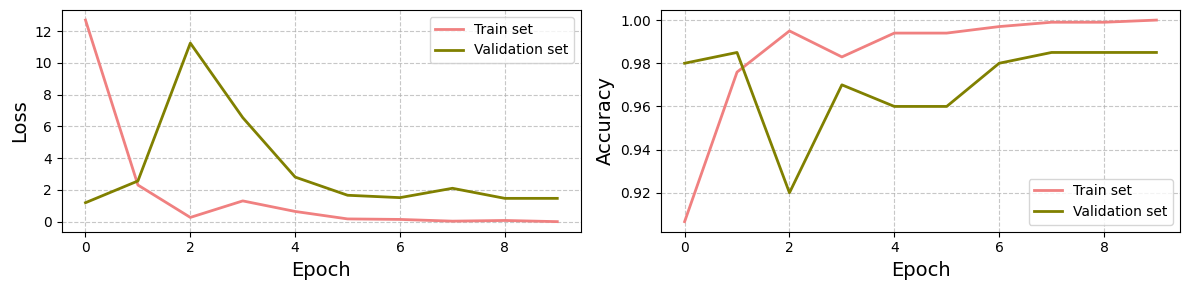

In [70]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(metrics["loss"], label= "Train set", color='lightcoral', linewidth=2)
plt.plot(metrics["val_loss"], label= "Validation set", color='olive', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(metrics["accuracy"], label= "Train set", color='lightcoral', linewidth=2)
plt.plot(metrics["val_accuracy"], label= "Validation set", color='olive', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [71]:
model.evaluate(test_features, test_labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9392 - loss: 7.4177  


[3.630976676940918, 0.9649999737739563]

#### Fine-tuning Method

In [72]:
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [73]:
inputs = layers.Input(shape=(180, 180, 3))
features = applications.vgg16.preprocess_input(inputs)
features = conv_base(features)
features = layers.Flatten()(features)
features = layers.Dense(128)(features)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(1, activation="sigmoid")(features)
model = Model(inputs, outputs, name="vgg16_fine_tuned")
model.compile(loss="binary_crossentropy",
              optimizer= optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
model.summary()

Model: "vgg16_fine_tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │      1,638,528 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            129 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,353,345 (62.38 MB)

 Trainable params: 8,718,081 (33.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [74]:
monitor = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - accuracy: 0.6320 - loss: 9.9100 - val_accuracy: 0.8650 - val_loss: 1.2432
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.8364 - loss: 2.2003 - val_accuracy: 0.9050 - val_loss: 0.8916
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.8938 - loss: 1.1444 - val_accuracy: 0.9250 - val_loss: 0.5820
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.9440 - loss: 0.7154 - val_accuracy: 0.9500 - val_loss: 0.4226
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9575 - loss: 0.3818 - val_accuracy: 0.9500 - val_loss: 0.3282
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9704 - loss: 0.3544 - val_accuracy: 0.9550 - val_loss: 0.2606
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.9834 - loss: 0.1642 - val_accuracy: 0.9650 - val_loss: 0.2287
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9752 - loss: 0.1717 - val_accuracy

In [75]:
y_test = np.array([])
pred = np.array([])
images = []

for batch_img, batch_label in test_dataset:
  y_test = np.concatenate([y_test, batch_label])
  pred  = np.concatenate([pred, model.predict(batch_img, verbose=0).reshape(-1,)])
  images.append(batch_img)

In [76]:
test_images = np.concatenate(images)

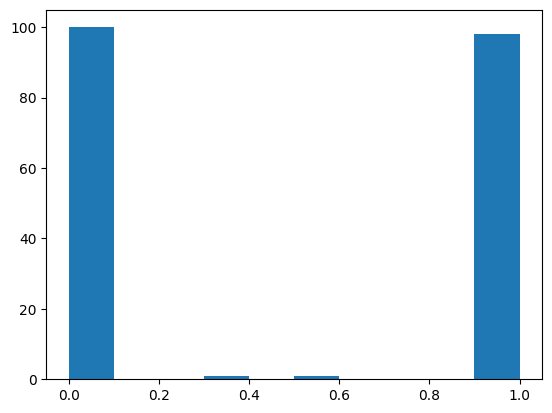

In [77]:
plt.hist(pred)
plt.show()

In [78]:
predictions = np.where(pred>0.5,1,0).reshape(-1,)

In [79]:
confusion_matrix(y_test,predictions)

array([[96,  4],
       [ 5, 95]])

In [85]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       100
         1.0       0.96      0.95      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200

